In [49]:
import pandas as pd
import numpy as np
import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
ratings = pd.read_csv('./data/ratings.csv')

In [4]:
ratings['timestamp'] = ratings['timestamp'].apply(datetime.datetime.fromtimestamp)
sample = ratings[ratings['timestamp'].apply(lambda x: x.date()) >= datetime.date(2013,3,31)]

In [5]:
df = spark.createDataFrame(sample)
(train_samp, test_samp) = df.randomSplit([0.8, 0.2])
model = ALS(userCol='userId', 
            itemCol='movieId', 
            ratingCol='rating').fit(train_samp)

In [6]:
predictions = model.transform(test_samp)
predictions.toPandas().head()

,userId,movieId,rating,timestamp,prediction
0,36445,148,4.5,2014-12-23 13:15:55,2.348654
1,3990,148,4.0,2015-02-01 14:04:54,2.398480
2,47935,471,4.0,2014-07-31 04:58:49,3.468599
3,108159,471,3.5,2015-03-06 00:13:30,3.147306
4,8085,471,4.0,2013-04-23 00:04:21,3.752974


In [7]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
evaluator.evaluate(predictions.na.drop())

0.7985887790406423

In [8]:
def multiALSrun(df, 
                k=3, 
                userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                metricName='rmse'):
    
    evaluations = np.array([])
    
    for i in range(0, k):
        (train, test) = df.randomSplit([(k-1.0)/k, 1.0/k])
        als = ALS(userCol=userCol, 
                  itemCol=itemCol, 
                  ratingCol=ratingCol)
        model = als.fit(train)
        pred = model.transform(test)
        evaluator = RegressionEvaluator(metricName=metricName, 
                                        labelCol='rating', 
                                        predictionCol='prediction')
        evaluation = evaluator.evaluate(pred.na.drop())
        print(f'k={i} rmse={evaluation}')
        evaluations = np.append(evaluations, evaluation)
    
    return np.mean(evaluations)

In [9]:
multiALSrun(df, k=5)

k=0 rmse=0.8022560739839893
k=1 rmse=0.8019144020478577
k=2 rmse=0.7991853163341229
k=3 rmse=0.8029248942835733
k=4 rmse=0.7992939861184246


0.8011149345535935

In [22]:
all_users = sample.userId.unique()
users_1000 = np.random.choice(all_users, 1000, replace=False)
sample_1000 = sample.loc[sample.userId.isin(users_1000)]
df_1000 = spark.createDataFrame(sample_1000)
(train_1000, test_1000) = df_1000.randomSplit([80.0, 20.0])

In [23]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating')
params = ParamGridBuilder().addGrid(als.rank, [1, 5, 10])\
                           .addGrid(als.maxIter, [20])\
                           .addGrid(als.regParam, [0.05, 0.1, 0.5])\
                           .build()

crossvalidator = CrossValidator(estimator=als, 
                                estimatorParamMaps=params, 
                                evaluator=evaluator,
                                numFolds=10)

In [24]:
modelCV = crossvalidator.fit(train_1000)

In [25]:
pred = modelCV.transform(test_1000)

In [28]:
evaluator.evaluate(pred.na.drop())

1.1506805379672558

In [56]:
def cvModel(n_users=1000):
    
    all_users = sample.userId.unique()
    nusers = np.random.choice(all_users, n_users, replace=False)
    nsample = sample.loc[sample.userId.isin(nusers)]
    df_n = spark.createDataFrame(nsample)
    (train_n, test_n) = df_n.randomSplit([80.0, 20.0])
    
    eval_rmse = RegressionEvaluator(metricName='rmse', 
                                    labelCol='rating', 
                                    predictionCol='prediction')
    eval_mae = RegressionEvaluator(metricName='mae', 
                                   labelCol='rating', 
                                   predictionCol='prediction')
    
    ranks = [10, 20, 30]
    regs = [0.01, 0.05, 0.1, 0.5]
    rmse_list = []
    mae_list = []
    
    for rank in ranks:
        for reg in regs:
            als = ALS(userCol='userId', 
                      itemCol='movieId', 
                      ratingCol='rating',
                      rank=rank,
                      regParam=reg)
            model = als.fit(train_n)
            pred = model.transform(test_n)
            rmse = eval_rmse.evaluate(pred.na.drop())
            mae = eval_mae.evaluate(pred.na.drop())
            # print(f'rank={rank}, regParam={reg}, rmse={evaluation}')
            rmse_list.append((rank, reg, rmse))
            mae_list.append((rank, reg, mae))
            
    best_rmse = sorted(rmse_list, key=lambda x: x[2])[0]
    best_mae = sorted(mae_list, key=lambda x: x[2])[0]
    
    results = {
        'rmse_list': rmse_list,
        'mae_list': mae_list,
        'best_rmse': best_rmse,
        'best_mae': best_mae,
    }
    
    return results

In [58]:
all_evals = []
user_size = len(all_users)
n_users = np.linspace(1000, user_size, 5)

for usize in n_users:
    all_evals.append(cvModel(n_users=int(usize)))

In [64]:
best_rmse_lst = [evaluation['best_rmse'][2] for evaluation in all_evals]
best_mae_lst = [evaluation['best_mae'][2] for evaluation in all_evals]

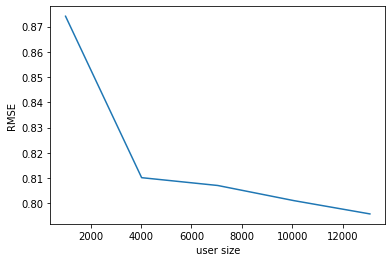

In [68]:
plt.plot(n_users, best_rmse_lst)
plt.xlabel('user size')
plt.ylabel('RMSE')
plt.show()

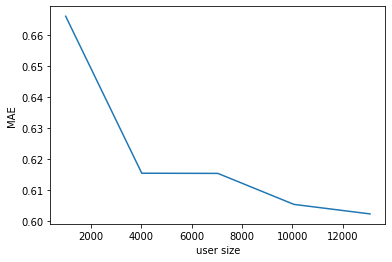

In [69]:
plt.plot(n_users, best_mae_lst)
plt.xlabel('user size')
plt.ylabel('MAE')
plt.show()